# 🎓 **Maestría en Inteligencia Artificial Aplicada**

## 📈 **Curso: Análisis de grandes volúmenes de datos (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Profesor titular:** Dr. Iván Olmos Pineda
#### 👩‍🏫 **Profesor asistence:** Verónica Sandra Guzmán de Valle

### 📊 **Actividad 3 | Aprendizaje supervisado y no supervisado**

#### 📅 **22 de mayo de 2025**

🧑‍💻 **A01016093:** Oscar Enrique García García 

# 1. Introducción teórica

Los modelos de Machine Learning se dividen en dos principales rubros: Aprendizaje supervisado y aprendizaje no supervisado.

## 🕵️ Aprendizaje Supervisado

En el aprendizaje supervisado, el modelo se entrena utilizando un conjunto de datos etiquetado, es decir, cada entrada de datos viene acompañada de su salida deseada. El objetivo es aprender una función que, a partir de las variables de entrada, prediga correctamente la salida.

Dentro del aprendizaje supervisado, se encuentran problemas de:

Clasificación: Predecir una categoría (por ejemplo, detectar si una transacción se trata de fraude o no).
Regresión: Predecir un valor continuo (por ejemplo, el precio de una casa).

### Algoritmos representativos:

- Regresión logística (Logistic Regression): LogisticRegression
- Regresión lineal: LinearRegression
- Árboles de decisión (Decision Trees): DecisionTreeClassifier / DecisionTreeRegressor
- Random Forest: RandomForestClassifier / RandomForestRegressor
- Gradient-Boosted Trees: GBTClassifier / GBTRegressor
- NaiveBayes (para clasificación probabilística)


### 🙈 Aprendizaje No Supervisado

El aprendizaje no supervisado se utiliza cuando los datos no están etiquetados. El objetivo es encontrar patrones, relaciones o estructuras ocultas en los datos.

Uno de los problemas a resolver dentro del aprendizaje no supervisado, son los relacionados a:

Agrupamiento (clustering): Agrupar objetos similares (por ejemplo, segmentación de clientes).

## Algortimos representativos:

- K-means: KMeans

## PySpark MLlib

- Librería original de PySpark.
- Basada en RDDs (Resilient Distributed Datasets).

## PySpark ML

- Librería recomendada actualmente para ML en Spark.
- Basada en DataFrames (similares a los de pandas).
- Mejor integración con SQL.
- Mejor optimización y paralelización.


# 2. Importar librerías

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import col, count, when, isnan, desc
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# 3. Crear sesión de Spark y lectura de archivo

In [29]:
spark = SparkSession.builder \
    .appName("Aprendizaje Supervisado y No Supervisado") \
    .getOrCreate()


In [30]:
df = spark.read.csv("/Users/oscgarcia/Documents/MNA/Análisis de Grandes Volúmenes de Datos/US_Accidents_Dec19.csv", header=True, inferSchema=True)
df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

Se decidió mantener únicamente las siguientes columnas ya que, como lo mencionamos en el documento del proyecto, el estudio se centraba en evaluar cómo afectaban las condiciones meteorológicas, a la severidad de los accidentes: Temperature(F), Weather_Condition, Severity, Humidity(%), Pressure(in), Wind_Direction, Wind_Speed(mph), Precipitation(in).

In [31]:
cols_to_select = ["Temperature(F)","Weather_Condition","Severity",
               "Humidity(%)", "Pressure(in)", "Wind_Direction",
               "Wind_Speed(mph)","Precipitation(in)"] #Se definen las columnas a mantener.

df = df.select(cols_to_select) #Se seleccionan únicamente las columnas definidas en el paso anterior.
df.show()

+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|
+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|          36.9|       Light Rain|       3|       91.0|       29.68|          Calm|           NULL|             0.02|
|          37.9|       Light Rain|       2|      100.0|       29.65|          Calm|           NULL|              0.0|
|          36.0|         Overcast|       2|      100.0|       29.67|            SW|            3.5|             NULL|
|          35.1|    Mostly Cloudy|       3|       96.0|       29.64|            SW|            4.6|             NULL|
|          36.0|    Mostly Cloudy|       2|       89.0|       29.65|            SW|            3.5|             NULL|
|          37.9|       Light Rain|       3|       97.0| 

# 4. Particionamiento

A continuación, se enlistan las particiones previamente definidas en el documento del proyecto y se integra el código para obtener muestras de tamaño "n", para cada una de las particiones. En este caso, se seleccionaron 10,000 registros para cada una de las particiones.

In [32]:
reglas_particionamiento = [
    {"Weather_Condition": "Fair", "Severity": 2},
    {"Weather_Condition": "Mostly Cloudy", "Severity": 2},
    {"Weather_Condition": "Cloudy", "Severity": 2},
    {"Weather_Condition": "Partly Cloudy", "Severity": 2},
    {"Weather_Condition": "Clear", "Severity": 2},
    {"Weather_Condition": "Light Rain", "Severity": 2},
    {"Weather_Condition": "Overcast", "Severity": 2},
    {"Weather_Condition": "Clear", "Severity": 3},
    {"Weather_Condition": "Fair", "Severity": 3},
    {"Weather_Condition": "Mostly Cloudy", "Severity": 3},
] #Se enlistan las particiones elegidas en el documento del proyecto.

muestras = [] #Se crea una lista vacía, que guardará las muestras.
tamaño_muestra_por_particion = 10000 #Se define el tamaño de la muestra (para cada partición).

for regla in reglas_particionamiento: #Se recorre la lista de reglas de particionamiento.
    condicion_clima = regla["Weather_Condition"]
    severidad = regla["Severity"]

    df_filtrado = df.filter(
        (col("Weather_Condition") == condicion_clima) &
        (col("Severity") == severidad)
    ).limit(tamaño_muestra_por_particion) #Se filtran los primeros n registros (tamaño de la muestra), que cumpla con las condiciones estipuladas en las reglas de particionamiento.

    muestras.append(df_filtrado) #Se agregan los datos a la lista de muestras

df_muestra_M = muestras[0]
for df_temp in muestras[1:]:
    df_muestra_M = df_muestra_M.union(df_temp) #Se unen todas las muestras en un solo dataframe.

df_muestra_M.show(5)


+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|
+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+
|          87.0|             Fair|       2|       35.0|       29.11|           SSE|            8.0|              0.0|
|          94.0|             Fair|       2|       31.0|       29.08|           SSE|            9.0|              0.0|
|          85.0|             Fair|       2|       44.0|       29.07|             S|           10.0|              0.0|
|          85.0|             Fair|       2|       44.0|       29.07|             S|           10.0|              0.0|
|          85.0|             Fair|       2|       44.0|       29.07|             S|           10.0|              0.0|
+--------------+-----------------+--------+-----------+-

In [ ]:
df_muestra_M.count() #Se verifica que existan 100,000 registros, que es el resultado de multiplicar el tamaño de la muestra (10,000) por el número de particiones (10).

ERROR:root:KeyboardInterrupt while sending command.][Stage 7588:>(0 + 0) / 23]3]
Traceback (most recent call last):
  File "/opt/anaconda3/envs/env-pyspark-mna/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/env-pyspark-mna/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/env-pyspark-mna/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
df_muestra_M.printSchema() #Se verifica el esquema del dataframe resultante.

root
 |-- Temperature(F): double (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)



# 5. Preparación de los datos

A continuación, se definen estrategias de imputación de valores nulos, dependiendo del tipo de dato de cada una de las columnas.

Para las variables numéricas, se optó por imputar la mediana; mientras que para las variables categóricas (en este caso es una sola: Wind Direction), se optó por imputar la moda.

In [ ]:
imputer = Imputer(
    inputCols=["Temperature(F)", "Humidity(%)", "Pressure(in)", "Precipitation(in)","Wind_Speed(mph)"],
    outputCols=["Temperature(F)_imputed", "Humidity(%)_imputed", "Pressure(in)_imputed", "Precipitation(in)_imputed","Wind_Speed(mph)_imputed"]
).setStrategy("median") #Se definen las columnas a las que se les aplicará la transformación

df_imputed = imputer.fit(df_muestra_M).transform(df_muestra_M) #Se aplica la transformación (imputar la media en valores nulos) a las columnas previamente definidas.


In [ ]:
# Calcular la moda de 'Weather_Condition'
mode_wind_dir = df_imputed.groupBy("Wind_Direction").count().orderBy(desc("count")).first()[0]

# Reemplazar valores nulos en 'Weather_Condition' con la moda
df_imputed = df_imputed.fillna({"Wind_Direction": mode_wind_dir})


Una vez aplicadas las transformaciones anteriores, se procede con los siguientes pasos:

1. Eliminar los registros que presenten nulos en las columnas restantes: Weather_Condition y Severity.

2. Convertir las variables categóricas a valores numéricos, por medio de StringIndexer, con el fin de que los modelos puedan trabajar únicamente con variables numéricas.

3. Se juntan todas las variables en una columna tipo "Vector", por medio de VectorAssembler, en una columna "features", con el fin de que los modelos trabajen directamente con esta columna.

4. Se construye el dataframe df_procesado, con el resultado de las transformaciones anteriores.

In [ ]:
df_imputed = df_imputed.dropna()

# Convertimos columnas categóricas a numéricas
indexers = [StringIndexer(inputCol="Weather_Condition", outputCol="Weather_Condition_idx"),
            StringIndexer(inputCol="Wind_Direction", outputCol="Wind_Direction_idx")
            ]

for indexer in indexers:
    df_imputed = indexer.fit(df_imputed).transform(df_imputed)

# Armamos el vector de características.
assembler = VectorAssembler(
    inputCols=["Temperature(F)_imputed","Weather_Condition_idx","Severity",
               "Humidity(%)_imputed", "Pressure(in)_imputed", "Wind_Direction_idx",
               "Wind_Speed(mph)_imputed","Precipitation(in)_imputed"],
    outputCol="features"
)

df_preprocesado = assembler.transform(df_imputed)
df_preprocesado.show(5)


+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+----------------------+-------------------+--------------------+-------------------------+-----------------------+---------------------+------------------+--------------------+
|Temperature(F)|Weather_Condition|Severity|Humidity(%)|Pressure(in)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Temperature(F)_imputed|Humidity(%)_imputed|Pressure(in)_imputed|Precipitation(in)_imputed|Wind_Speed(mph)_imputed|Weather_Condition_idx|Wind_Direction_idx|            features|
+--------------+-----------------+--------+-----------+------------+--------------+---------------+-----------------+----------------------+-------------------+--------------------+-------------------------+-----------------------+---------------------+------------------+--------------------+
|          87.0|             Fair|       2|       35.0|       29.11|           SSE|            8.0|              0.0| 

# 6. Preparación del conjunto de entrenamiento y prueba

A continuación se construyen los sets de entrenamiento y de prueba, en una distribución 70-30. Estos sets nos permitirán entrenar nuestros modelos y, posteriormente, evaluar el rendimiento de los mismos, en datos "desconocidos" por el modelo.

Dado que, con base en las particiones, podemos darnos cuenta que se trata de un problema de clases desbalanceadas (70% severity 2 y 30% severity 3), se decidió crear un código que mantenga esta proporción en ambos conjuntos

In [ ]:
# Se filtra por cada clase de Severity
df_severity2 = df_preprocesado.filter(F.col("Severity") == 2)
df_severity3 = df_preprocesado.filter(F.col("Severity") == 3)

# Se aplica randomSplit por separado
train_2, test_2 = df_severity2.randomSplit([0.7, 0.3], seed=42)
train_3, test_3 = df_severity3.randomSplit([0.7, 0.3], seed=42)

# Unir las divisiones para formar train y test balanceados
train_data = train_2.union(train_3)
test_data = test_2.union(test_3)


# 7. Construcción de modelos de aprendizaje supervisado y no supervisado

A continuación se realizan dos experimentos (uno para aprendizaje supervisado (RandomForest) y otro para aprendizaje no supervisado (Kmeans: clustering).

Adicionalmente, se evalúan los modelos generados, con base en el accuracy y en el Silhoutte score, respectivamente.

## Random Forest

Primero, se realiza el modelo de Random Forest, que pretende predecir la severidad del accidente, con base en las variables de entrada.

In [ ]:
#Se crea el modelo Random Forest, incluyendo el nombre de la columna target (severity)
#y las variables de entrada (columna tipo vector: features)
modelo_rf = RandomForestClassifier(labelCol="Severity", featuresCol="features")

#Se entrena el modelo definido en el paso anterior, con base en el conjunto de entrenamiento.
modelo_entrenado = modelo_rf.fit(train_data)

#Se hacen predicciones para el conjunto de pruebas.
predicciones = modelo_entrenado.transform(test_data)

#Se crea un evaluador y se evalúa el modelo (accuracy), con base en las predicciones realizadas en el paso anterior.
evaluador = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
precision = evaluador.evaluate(predicciones)
print(f"Precisión: {precision}")


Precisión: 1.0


In [ ]:
predicciones.groupBy("Severity", "prediction").count().show()

+--------+----------+-----+
|Severity|prediction|count|
+--------+----------+-----+
|       2|       2.0| 8667|
|       3|       3.0| 3064|
+--------+----------+-----+



In [ ]:
for metric in ["accuracy", "f1", "weightedRecall", "weightedPrecision"]:
    evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName=metric)
    result = evaluator.evaluate(predicciones)
    print(f"{metric}: {result:.4f}")

accuracy: 1.0000


f1: 1.0000


weightedRecall: 1.0000


weightedPrecision: 1.0000


### Conclusiones Random Forest

## KMeans

A pesar de que, con base en los datos, sabemos que existen 2 clústeres (severity:2, severity:3), se construyen diferentes modelos KMeans (de 2 a 4 clústeres) con el fin de comprobar el número óptimo de clústeres (2), que nos permitirán agrupar los datos, con base en las variables de entrada.

Es importante mencionar que, dado que se trata de un modelo no supervisado, se aplica el modelo al set completo (df_preprocesado) y no para un conjunto de entrenamientos y pruebas, por separado.

### Comprobación de número de clústeres

In [ ]:
#Se crea una lista vacía, que guardará cada uno de los scores de los modelos.
cost = []

#Se crea un loop de 2 a 4, para evaluar los diferentes modelos (con base en el número de clusters)
for k in range(2,4):
    #Se crea el modelo
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    #Se entrena el modelo.
    model = kmeans.fit(df_preprocesado)
    #Se aplica el modelo.
    predictions = model.transform(df_preprocesado)
    #Se evalúa el modelo y se guarda el score de Silhoutte.
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    cost.append(silhouette)

#Se grafica el resultado.
plt.figure(figsize=(8, 5))
plt.plot(range(2, 4), cost, marker='o')
plt.xlabel('Número de clústeres')
plt.ylabel('Score de Silueta')
plt.title('Método del Codo para KMeans')
plt.show()


ERROR:root:KeyboardInterrupt while sending command.][Stage 6927:>(0 + 0) / 23]3]
Traceback (most recent call last):
  File "/opt/anaconda3/envs/env-pyspark-mna/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/env-pyspark-mna/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/env-pyspark-mna/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

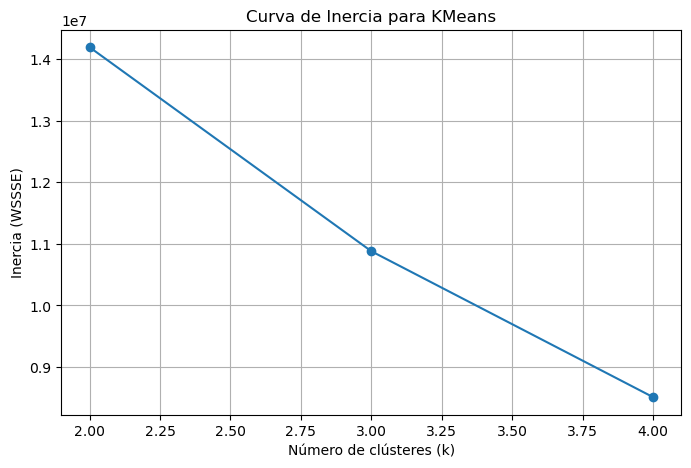

In [ ]:
# Lista para almacenar la inercia (WSSSE)
wssse_list = []

# Rango de valores de k a probar
k_values = list(range(2, 4))

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(42).setFeaturesCol("features")
    model = kmeans.fit(df_preprocesado)
    
    # Compute cost (WSSSE)
    wssse = model.summary.trainingCost
    wssse_list.append(wssse)

# Graficar curva de inercia
plt.figure(figsize=(8, 5))
plt.plot(k_values, wssse_list, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia (WSSSE)')
plt.title('Curva de Inercia para KMeans')
plt.grid(True)
plt.show()


## 🧠 Selección del número óptimo de clústeres

Para determinar el número óptimo de clústeres en el modelo KMeans, se analizaron dos criterios:

### 1. Score de Silueta

- El score de silueta es una métrica que mide la calidad del agrupamiento, combinando cohesión (qué tan cerca están los puntos dentro de un clúster) y separación (qué tan lejos están de otros clústeres).
- En el gráfico, se observa que el valor máximo del score se obtiene cuando **k = 2**, con una puntuación superior a 0.65.
- A partir de k = 3, el score disminuye progresivamente, lo que sugiere una menor calidad de agrupamiento.

📌 **Conclusión:** el score de silueta sugiere que **2 clústeres es la mejor elección**.

---

### 2. Curva de Inercia (WSSSE)

- La inercia o WSSSE (Within Set Sum of Squared Errors) mide la compacidad de los clústeres: a menor valor, mayor compacidad.
- Aunque la inercia disminuye conforme se incrementa el número de clústeres (lo cual es esperado), **la curva no muestra un "codo" claramente definido**, lo cual indica que no hay una mejora marginal significativa al pasar de 2 a más clústeres.

📌 **Conclusión:** aunque la inercia mejora con más clústeres, no lo hace de manera abrupta o significativa, por lo que **no contradice la elección de k = 2**.

---

### ✅ Veredicto final:
Basado en ambos criterios, se concluye que el número óptimo de clústeres es:

#### 👉 **2 clústeres: Esto confirma nuestra declaración inicial de tener 2 clústeres, con base en las particiones definidas: serverity 2 y severity 3**


### Modelo final KMeans

A continuación se construye y se evalúa el modelo con 2 clústeres, de forma individual.

In [34]:
#Se crea el modelo con 2 clústeres.
kmeans = KMeans().setK(2).setSeed(42).setFeaturesCol("features")

#Se entrena el modelo
modelo_kmeans = kmeans.fit(df_preprocesado)

#Se aplica el modelo
predicciones = modelo_kmeans.transform(df_preprocesado)

#Se evalúa el modelo, con base en el score de Silhoutte
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predicciones)

print(f"Score de silueta para k=2: {silhouette:.4f}")

#Se muestran las predicciones realizadas.
predicciones.select("prediction").groupBy("prediction").count().show()

Score de silueta para k=2: 0.6636


+----------+-----+
|prediction|count|
+----------+-----+
|         1|14079|
|         0|25143|
+----------+-----+



In [35]:
#Se muestra el valor real vs la predicción hecha por el modelo.
predicciones.groupBy("severity","prediction").count().show()

+--------+----------+-----+
|severity|prediction|count|
+--------+----------+-----+
|       2|         1| 7903|
|       2|         0|21194|
|       3|         1| 6176|
|       3|         0| 3949|
+--------+----------+-----+



### Conclusiones KMeans

#